* E. Brunner and U. Munzel. The nonparametric Behrens-Fisher problem: Asymptotic theory and a small-sample
approximation. Biometrical Journal, 42:17–25, 2000.
\[[pdf](https://www.researchgate.net/profile/Edgar-Brunner/publication/264799502_Nonparametric_Hypotheses_and_Rank_Statistics_for_Unbalanced_Factorial_Designs/links/5756a00408ae155a87bc5c8c/Nonparametric-Hypotheses-and-Rank-Statistics-for-Unbalanced-Factorial-Designs.pdf)\]

* Karin Neubert and Edgar Brunner, A studentized permutation test for the non-parametric Behrens-Fisher problem, Computational Statistics and Data Analysis, Vol. 51, pp. 5192-5204 (2007).
https://doi.org/10.1016/j.csda.2006.05.024

* Claus P. Nowak, Markus Pauly, Edgar Brunner. The nonparametric Behrens-Fisher problem in small samples.
https://arxiv.org/abs/2208.01231

In [1]:
using Base.Threads
using Distributions
using PrettyPrinting
using QuadGK
using Random
using RCall
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, size=(400, 250),
    titlefontsize=10, guidefontsize=8, tickfontsize=6)

x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
"""
    nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])

`[1,2,…,n]` からの重複無しの `t` 個の組み合わせ `c` をすべて生成したい.

`nextcombination!(n, t, c)` は配列で表現された組み合わせ `c` をその次の組み合わせに書き換えて, `c` を返す.

初期条件を `c = typeof(t)[min(t-1, i) for i in 1:t]` にすると, `binomial(n, t)` 回の `nextcombination!(n, t, c)` ですべての組み合わせが生成される.
"""
function nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])
    t == 0 && return c
    @inbounds for i in t:-1:1
        c[i] += 1
        c[i] > (n - (t - i)) && continue
        for j in i+1:t
            c[j] = c[j-1] + 1
        end
        break
    end
    c
end

"""
    mycombinations!(n::Integer, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, `[1,2,…,n]` からの重複無しの `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(n::Integer, t, c)
    for i in 1:t c[i] = min(t - 1, i) end
    (nextcombination!(n, t, c) for _ in 1:binomial(n, t))
end

"""
    mycombinations!(a, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, 配列 `a` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(a, t, c)
    t < 0 && (t = length(a) + 1)
    (view(a, indices) for indices in mycombinations!(length(a), t, c))
end

"""
    mycombinations(x, t)

`x` が整数ならば `[1,2,…,x]` からの, `x` が配列ならば `x` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
mycombinations(x, t) = mycombinations!(x, t, Vector{typeof(t)}(undef, t))

mycombinations

In [3]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [4]:
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

function statistics_brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        RRx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        RRy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(RRy) - mean(RRx) + n)/(m + n)
    sx2, sy2 = var(RRx)/n^2, var(RRy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

function pvalue_brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, RRx, RRy; p).pvalue
end

function brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, RRx, RRy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_location(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, RRx, RRy; p)
    end
    locmin = minimum(X) - maximum(Y) - 1
    locmax = maximum(X) - minimum(Y) + 1
    N = length(X) + length(Y)
    loccent = argmax(a -> pvalue_location(a), range(locmin, locmax, round(Int, 16√N)))
    confint_location = [
        find_zero(a -> pvalue_location(a) - α, (locmin, loccent))
        find_zero(a -> pvalue_location(a) - α, (loccent, locmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, confint_location,
        pvalue_location, locmin, locmax)
end

function show_plot_brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        kwargs...
    )
    @show X Y
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, confint_location,
        pvalue_location, locmin, locmax) = brunner_munzel(X, Y, RRx, RRy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p, confint_location))
    println()
    @show median(X), median(Y)
    plot(pvalue_location, locmin, locmax; label="")
    title!("pvalue_location")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)
end

show_plot_brunner_munzel (generic function with 4 methods)

In [5]:
X = randn(10)
Y = randn(10)
@show locmin = minimum(X) - maximum(Y) - 1
@show locmax = maximum(X) - minimum(Y) + 1
pvalue_brunner_munzel(X, Y)

locmin = (minimum(X) - maximum(Y)) - 1 = -3.9826663510956974
locmax = (maximum(X) - minimum(Y)) + 1 = 4.3922478591849075


0.8863279641987241

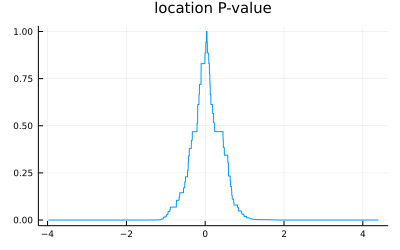

In [6]:
plot(a -> pvalue_brunner_munzel(X, Y .+ a), locmin, locmax; label="", title="location P-value")

https://okumuralab.org/~okumura/stat/brunner-munzel.html

```R
x = c(1,2,1,1,1,1,1,1,1,1,2,4,1,1)
y = c(3,3,4,3,1,2,3,1,1,5,4)
brunnermunzel.test(x, y)

data:  x and y
Brunner-Munzel Test Statistic = 3.1375, df = 17.683, p-value = 0.005786
95 percent confidence interval:
 0.5952169 0.9827052
sample estimates:
P(X<Y)+.5*P(X=Y) 
        0.788961 
```

X = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1]
Y = [3, 3, 4, 3, 1, 2, 3, 1, 1, 5, 4]
(phat = 0.788961038961039,
 sehat = 0.09210009046816862,
 tvalue = 3.1374674823029505,
 df = 17.682841979481545,
 p = 0.5,
 pvalue = 0.005786208666151463,
 α = 0.05,
 confint_p = [0.5952168642537363, 0.9827052136683416],
 confint_location = [-2.0000000000000004, -5.551115123125783e-17])
(median(X), median(Y)) = (1.0, 3.0)


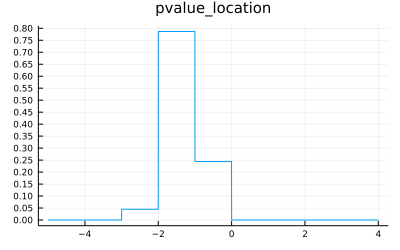

In [7]:
X = [1,2,1,1,1,1,1,1,1,1,2,4,1,1]
Y = [3,3,4,3,1,2,3,1,1,5,4]
show_plot_brunner_munzel(X, Y)

In [8]:
function permutation_tvalues_brunner_munzel(X, Y;
        XandY = Vector{Float64}(undef, length(X)+length(Y))
    )
    m, n = length(X), length(Y)
    N = m + n
    @views XandY[1:m] .= X
    @views XandY[m+1:N] .= Y
    allindices = 1:N
    RRx = similar(X, Float64)
    RRy = similar(Y, Float64)
    ccomb = Vector{Int}(undef, n)
    Tval = Vector{Float64}(undef, binomial(N, m))
    for (k, comb) in enumerate(mycombinations(1:N, m))
        j = 0
        for i in 1:N
            if i ∉ comb
                j += 1
                ccomb[j] = i
            end
        end
        Tval[k] = statistics_brunner_munzel(
            view(XandY, comb), view(XandY, ccomb), RRx, RRy).tvalue
    end
    Tval
end

function pvalue_brunner_munzel_perm(X, Y,
        Tval = permutation_tvalues_brunner_munzel(X, Y),
        tval = statistics_brunner_munzel(X, Y).tvalue;
        le = ⪅
    )
    pvalue_perm = mean(T -> le(abs(tval), abs(T)), Tval)
end

pvalue_brunner_munzel_perm (generic function with 3 methods)

https://okumuralab.org/~okumura/stat/brunner-munzel.html

```
bm = brunner.munzel.test(x, y)$statistic
n1 = length(x)
n2 = length(y)
N = n1 + n2
xandy = c(x, y)
foo = function(X) {
  brunner.munzel.test(xandy[X], xandy[-X])$statistic
}
z = combn(1:N, n1, foo)
mean(abs(z) >= abs(bm))
```

>結果は 0.008037645 となりました。

X = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1]
Y = [3, 3, 4, 3, 1, 2, 3, 1, 1, 5, 4]
(m, n) = (length(X), length(Y)) = (14, 11)
  5.044472 seconds (1.11 M allocations: 91.015 MiB, 2.54% gc time, 7.68% compilation time)
pvalue_brunner_munzel_perm(X, Y, Tval) = 0.008037645264055279


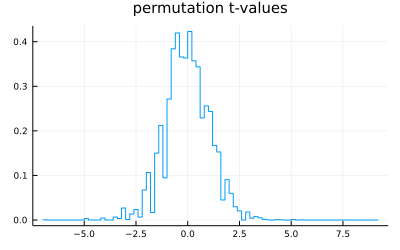

In [9]:
X = [1,2,1,1,1,1,1,1,1,1,2,4,1,1]
Y = [3,3,4,3,1,2,3,1,1,5,4]
@show X Y
@show m, n = length(X), length(Y)

Tval = @time permutation_tvalues_brunner_munzel(X, Y)
@show pvalue_brunner_munzel_perm(X, Y, Tval)
stephist(Tval; norm=true, bin=101, label="", title="permutation t-values")

https://github.com/toshi-ara/brunnermunzel/issues/14

https://github.com/toshi-ara/brunnermunzel/files/4395032/mwe.R.zip

In [10]:
R"""
library(brunnermunzel)
set.seed(1290)
reps = 100
xx = c()
yy = c()
pval_R = numeric(reps)
for (i in seq_len(reps)){
  x = rnorm(5)
  y = rnorm(5)
  
  xx = c(xx, x)
  yy = c(yy, y)
  
  res_bm_perm <- brunnermunzel.permutation.test(x,y)
  pval_R[i] <- res_bm_perm$p.value
}
"""

@rget xx yy pval_R
XX = reshape(xx, 5, 100)
YY = reshape(yy, 5, 100)

pval_J = zeros(100)
pval_J_le = zeros(100)
for i in 1:100
    pval_J[i]    = pvalue_brunner_munzel_perm(XX[:,i], YY[:,i]; le = ⪅)
    pval_J_le[i] = pvalue_brunner_munzel_perm(XX[:,i], YY[:,i]; le = ≤)
end

In [11]:
@show pval_J - pval_J_le;

pval_J - pval_J_le = [0.0, 0.0, 0.007936507936507936, 0.023809523809523808, 0.023809523809523808, 0.0793650793650793, 0.0, 0.0, 0.007936507936507936, 0.0357142857142857, 0.0, 0.015873015873015928, 0.015873015873015872, 0.0, 0.015873015873015872, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.023809523809523836, 0.015873015873015928, 0.011904761904761918, 0.0, 0.015873015873015928, 0.0, 0.003968253968253968, 0.0, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.015873015873015928, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.0, 0.007936507936507936, 0.007936507936507936, 0.011904761904761918, 0.007936507936507936, 0.03968253968253965, 0.0, 0.007936507936507936, 0.0, 0.05555555555555547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015872, 0.015873015873015872, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015928, 0.007936507936507964, 0.007936507936507964, 0.0, 0

In [12]:
idx = @show findall(pval_J .!= pval_J_le)
length(idx)

findall(pval_J .!= pval_J_le) = [3, 4, 5, 6, 9, 10, 12, 13, 15, 19, 21, 22, 23, 25, 27, 32, 34, 36, 40, 42, 44, 47, 48, 49, 50, 51, 53, 55, 68, 69, 71, 78, 79, 80, 82, 86, 89, 90, 92, 94]


40

In [13]:
@show pval_R - pval_J_le;

pval_R - pval_J_le = [0.0, 0.0, 0.007936507936507936, 0.023809523809523808, 0.023809523809523808, 0.0793650793650793, 0.0, 0.0, 0.007936507936507936, 0.0357142857142857, 0.0, 0.015873015873015928, 0.015873015873015872, 0.0, 0.015873015873015872, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.023809523809523836, 0.007936507936507908, 0.011904761904761918, 0.0, 0.015873015873015928, 0.0, 0.003968253968253968, 0.0, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.00793650793650802, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.0, 0.007936507936507936, 0.007936507936507936, 0.011904761904761918, 0.007936507936507936, 0.03968253968253965, 0.0, 0.007936507936507936, 0.0, 0.05555555555555547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015872, 0.015873015873015872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007936507936507908, 0.007936507936507964, 0.007936507936507964, 0.0, 0.00396825396825395

In [14]:
idx = @show findall(pval_R .!= pval_J_le)
length(idx)

findall(pval_R .!= pval_J_le) = [3, 4, 5, 6, 9, 10, 12, 13, 15, 19, 21, 22, 23, 25, 27, 32, 34, 36, 40, 42, 44, 47, 48, 49, 50, 51, 53, 55, 68, 69, 78, 79, 80, 82, 86, 89, 90, 92, 94]


39

In [15]:
@show pval_J - pval_R;

pval_J - pval_R = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00793650793650802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007936507936507908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00793650793650802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
idx = @show findall(.!(pval_J .≈ pval_R))
length(idx)

findall(.!(pval_J .≈ pval_R)) = [22, 34, 71, 78]


4

In [17]:
all(pval_J .≥ pval_R .≥ pval_J_le)

true

なるほど！

https://github.com/toshi-ara/brunnermunzel/issues/14

に書いてあるように, 22, 34, 71 and 78 の4つで, 値が一致していない.

〇〇以下または〇〇以上の判定を $x \approx y$ のときも true にする必要があるのだが, その部分で違いが生じているものと思われる.

現時点では https://CRAN.R-project.org/package=brunnermunzel  にアクセスすると,

>Package ‘brunnermunzel’ was removed from the CRAN repository.
>
>Formerly available versions can be obtained from the [archive](https://cran.r-project.org/src/contrib/Archive/brunnermunzel/).
>
>Archived on 2022-03-04 as check problems were not corrected in time. , LENGTH_1 checks.
>
>A summary of the most recent check results can be obtained from the [check results archive](https://cran-archive.r-project.org/web/checks/2022/2022-03-04_check_results_brunnermunzel.html).
>
>Please use the canonical form https://CRAN.R-project.org/package=brunnermunzel to link to this page.

と表示される.

In [18]:
m, n = 10, 10
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
@show pval_brmu = pvalue_brunner_munzel(X, Y)
@show pval_perm = pvalue_brunner_munzel_perm(X, Y);

pval_brmu = pvalue_brunner_munzel(X, Y) = 0.10455893189580186
pval_perm = pvalue_brunner_munzel_perm(X, Y) = 0.10785035398038494


X = [1.7073712586406489, 2.0015123867881837, -1.3910227569932225, 0.641010650010951, -0.42104687252475687, -0.08960971607588541, -0.5906990656979468, -1.0866664518222944, -1.309808553532723, -1.4291955289153362]
Y = [1.21989431260905, -1.320602573469216, 0.3797567476245794, 3.4758650653442715, -0.04932966511613733, 1.2771307909192904, 1.1118538653249483, 5.147883686030256, 0.4009211177299524, 0.25808769001051707, -0.20182749774932315, 1.1672285358402894, 4.036386924888264, 2.491110375788877, -0.14103769778492237, 2.7506370515109926, -3.259797805282148, 0.8405040289230507, 2.392931684128441, 1.3709633118172209]
(phat = 0.75,
 sehat = 0.10056855914111178,
 tvalue = 2.485866379463735,
 df = 18.385702920172452,
 p = 0.5,
 pvalue = 0.022742714988590425,
 α = 0.05,
 confint_p = [0.5390305665719614, 0.9609694334280386],
 confint_location = [-2.4770370893730127, -0.3717172074086195])
(median(X), median(Y)) = (-0.5058729691113518, 1.1395412005826189)


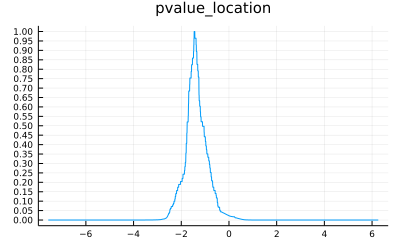

In [19]:
Random.seed!(4)

m, n = 10, 20
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
show_plot_brunner_munzel(X, Y)

X = [0.0669507984151622, -0.4598010273372653, 0.7884651938551743, -1.269055407672929, -2.987716126941856, 2.5348622708413586, -0.41513327407568945, 0.1464412107331252, -0.6341984385578544, 0.30181346805750026]
Y = [2.1395776386845093, 0.5275604560765014, 2.997019879455472, 1.905237112105788, 1.1438660865286125, -1.6418898011020826, 0.5437265501961129, 1.0380993815245778, 3.1101488881037627, 2.9609811333010914, -3.3620381836428104, -3.5879448616110166, 1.7909303164016783, 0.8791489384440188, -3.491243578330837, 0.7972778913764677, -0.2626730756003307, -0.5622511994900274, 2.359437095602121, 0.7717379186518556]
(phat = 0.675,
 sehat = 0.1049296617650541,
 tvalue = 1.667783895004246,
 df = 27.705176944214784,
 p = 0.5,
 pvalue = 0.10662428006873317,
 α = 0.05,
 confint_p = [0.45995823964489857, 0.8900417603551015],
 confint_location = [-2.2060635904773678, 0.3296238740154929])
(median(X), median(Y)) = (-0.17409123783026362, 0.8382134149102431)


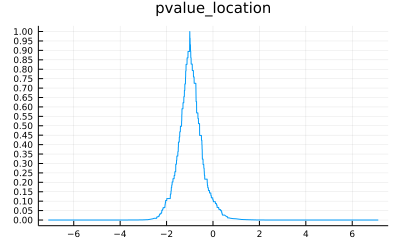

In [20]:
m, n = 10, 20
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
show_plot_brunner_munzel(X, Y)

X = [-0.20593384223576372, 0.19758865438238965, 1.4902648654501802, 0.3361328942406075, -1.5009319639611822, 0.58496943193043, 0.5733003064816136, 0.7177220442975942, -0.3134746538531026, -1.4496997652348917, -0.9496593169004386, -0.8414438427102041, -0.6731127857261889, -0.5609984468903895, 0.7999065806954451, -0.394303783920913, 0.44490451226383004, 1.298330710146699, 1.0193658048427767, 0.4171834220106664, 1.3675033947586746, 0.781647721694465, -1.2229863167295745, -0.820270044107991, 2.6549108544144526, -1.420958994674455, -0.8341425111643971, 0.26491415388363554, -1.3293173968732446, -0.044220726129046456, 0.14626038723040533, -0.5809784394560562, -1.3050855605893217, -2.8526355112827053, 1.263135912636373, 0.2651851022105141, -0.32170785127708956, -0.9192537042778153, 1.872342508136982, 0.6587336244212799, 0.13413751371438828, 1.67985001105524, -1.5029625601260252, 0.677705927749241, -1.3819680069550535, -0.5910965839957716, -1.6312511532057983, 0.6008628162294197, 1.340509982150

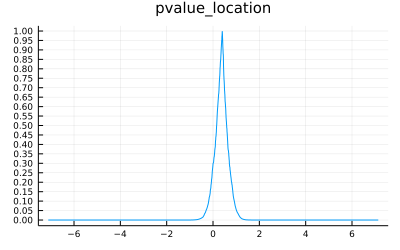

In [21]:
m, n = 100, 50
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
show_plot_brunner_munzel(X, Y)

X = [9, 10, 7, 6, 5, 4, 3, 8, 6, 8]
Y = [8, 18, 3, 16, 1, 16, 16, 20, 5, 2, 3, 14, 15, 19, 1, 20, 20, 6, 13, 19]
(phat = 0.6725,
 sehat = 0.1005725567999867,
 tvalue = 1.715179622439735,
 df = 20.71835365424782,
 p = 0.5,
 pvalue = 0.10123190720539166,
 α = 0.05,
 confint_p = [0.46317465971191163, 0.8818253402880883],
 confint_location = [-10.999999999999998, 0.9999999999999997])
(median(X), median(Y)) = (6.5, 14.5)


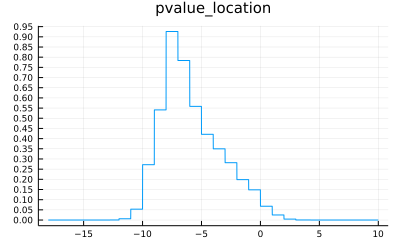

In [22]:
Random.seed!(4)

m, n = 10, 20
X, Y = rand(1:m, m), rand(1:n, n)
show_plot_brunner_munzel(X, Y)

X = [1, 5, 7, 8, 9, 9, 4, 2, 5, 6]
Y = [14, 4, 16, 12, 6, 15, 5, 13, 12, 16, 20, 20, 7, 4, 17, 12, 5, 4, 9, 7]
(phat = 0.765,
 sehat = 0.08626255311649104,
 tvalue = 3.0720166564295583,
 df = 27.60349766038036,
 p = 0.5,
 pvalue = 0.004741546491682432,
 α = 0.05,
 confint_p = [0.5881847509519754, 0.9418152490480246],
 confint_location = [-8.999999999999998, -1.9999999999999993])
(median(X), median(Y)) = (5.5, 12.0)


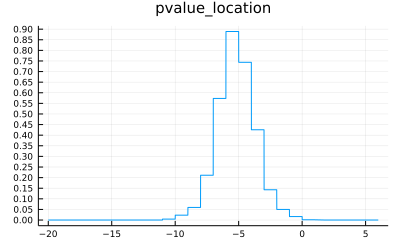

In [23]:
m, n = 10, 20
X, Y = rand(1:m, m), rand(1:n, n)
show_plot_brunner_munzel(X, Y)

In [24]:
function prob_x_le_y(distx, disty, a=0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

function tieshift(distx, disty; probtie=0.5)
    #s = max(std(distx), std(disty))
    #m = median(distx) - median(disty)
    #find_zero(a -> prob_x_le_y(distx, disty, a) - probtie,
    #    (amin, amax), Bisection())
    find_zero(a -> prob_x_le_y(distx, disty, a) - probtie, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [25]:
function sim_brunner_mumzel_and_welch(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 10^6)
    pval_bm = Vector{Float64}(undef, L)
    pval_w = Vector{Float64}(undef, L)
    tmpX = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpY = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    tmpRRx = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpRRy = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(distx, tmpX[threadid()])
        Y = rand!(disty, tmpY[threadid()])
        pval_bm[i] = pvalue_brunner_munzel(X, Y, tmpRRx[threadid()], tmpRRy[threadid()])
        pval_w[i] = pvalue_welch(X, Y)
    end
    ecdf(pval_bm), ecdf(pval_w)
end

function printcompact(io, xs...)
    print(IOContext(io, :compact => true), xs...)
end

function distname(dist)
    replace(sprint(printcompact, dist), r"\{[^\}]*\}"=>"")
end

function plot_ecdf(ecdf_pval, distx, disty, m, n, a;
        testname = "", kwargs...)
    plot(p -> ecdf_pval(p), 0, 0.1; label="ecdf of P-values")
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(legend=:topleft)
    plot!(xtick=0:0.01:0.1, ytick=0:0.01:1)
    plot!(xguide="nominal significance level α", 
        yguide="probability of P-value < α")
    s = (a < 0 ? "" : "+") * string(round(a; digits=4))
    title!("$(testname)X: $(distname(distx)), m=$m\n\
        Y: $(distname(disty))$s, n=$n")
    plot!(size=(400, 450))
    plot!(; kwargs...)
end

function plot_pvals(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 10^6, a = nothing, Δμ = nothing, kwargs...)
    @show (mean(distx), std(distx))
    @show (mean(disty), std(disty))
    
    if isnothing(a)
        @show a = tieshift(distx, disty)
        @show prob_x_le_y(distx, disty + a)
    else
        @show a
        @show median(distx) - median(disty)
    end
    if isnothing(Δμ)
        @show Δμ = mean(distx) - mean(disty)
        @show mean(distx), mean(disty + Δμ)
    else
        @show Δμ
        @show mean(distx), mean(disty + Δμ)
    end
        
    ecdf_bm, ecdf_w = @time sim_brunner_mumzel_and_welch(;
        distx = distx,
        disty = disty + a,
        m, n, L, kwargs...)
    ymax = max(ecdf_bm(0.1), ecdf_w(0.1))
    P1 = plot_ecdf(ecdf_bm, distx, disty, m, n, a;
        testname="Brunner-Munzel test\n",
        ylim=(-0.002, 1.02*ymax), kwargs...)
    P2 = plot_ecdf(ecdf_w, distx, disty, m, n, Δμ;
        testname="Welch t-test\n",
        ylim=(-0.002, 1.02*ymax), kwargs...)
    plot(P1, P2; size=(800, 450), topmargin=3.5Plots.mm)
end

plot_pvals (generic function with 1 method)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.468075 seconds (95.42 k allocations: 50.937 MiB, 3.05% gc time, 17.74% compilation time)


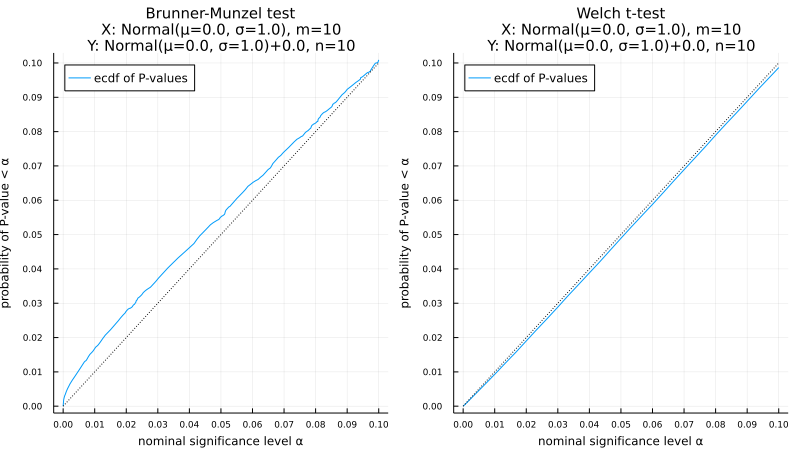

In [26]:
plot_pvals(; distx = Normal(0, 1), disty = Normal(0, 1), m = 10, n = 10)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.372140 seconds (238 allocations: 45.801 MiB)


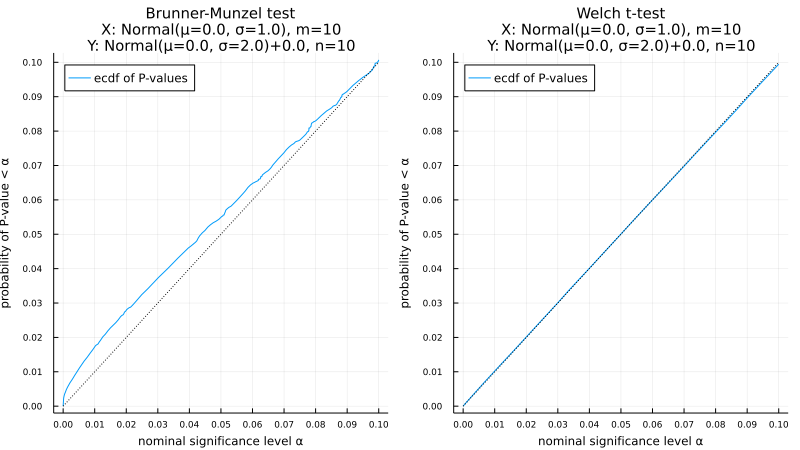

In [27]:
plot_pvals(; distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (4.4816890703380645, 5.874743663340262)
a = tieshift(distx, disty) = -1.4744426128871542
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = -2.8329677996379363
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.461818 seconds (53.75 k allocations: 48.591 MiB, 3.42% gc time, 10.53% compilation time)


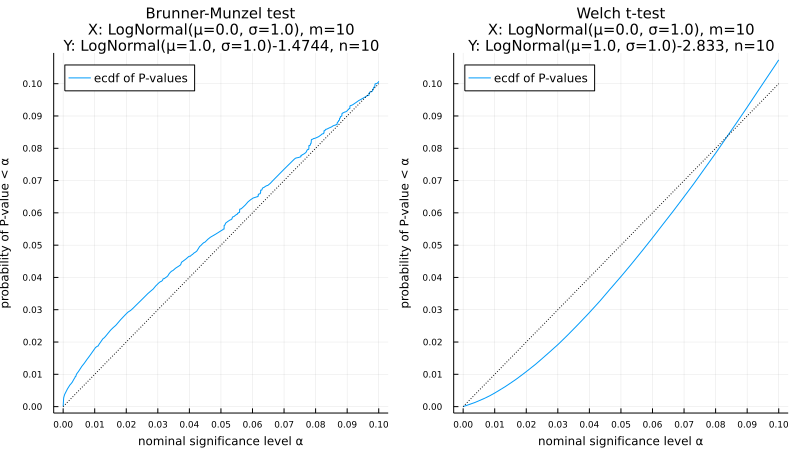

In [28]:
plot_pvals(; distx = LogNormal(), disty = LogNormal(1), m = 10, n = 10)

(mean(distx), std(distx)) = (NaN, NaN)
(mean(disty), std(disty)) = (NaN, NaN)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
Δμ = 0.0
(mean(distx), mean(disty + Δμ)) = (NaN, NaN)
  0.573054 seconds (252.65 k allocations: 59.058 MiB, 21.28% compilation time)


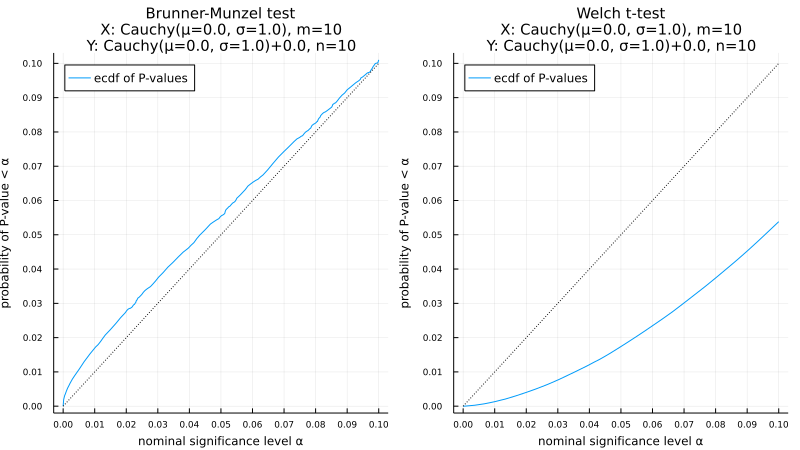

In [29]:
plot_pvals(; distx = Cauchy(0, 1), disty = Cauchy(0, 1), m = 10, n = 10, Δμ = 0.0)

(mean(distx), std(distx)) = (NaN, NaN)
(mean(disty), std(disty)) = (NaN, NaN)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
Δμ = 0.0
(mean(distx), mean(disty + Δμ)) = (NaN, NaN)
  0.436962 seconds (235 allocations: 45.800 MiB, 5.10% gc time)


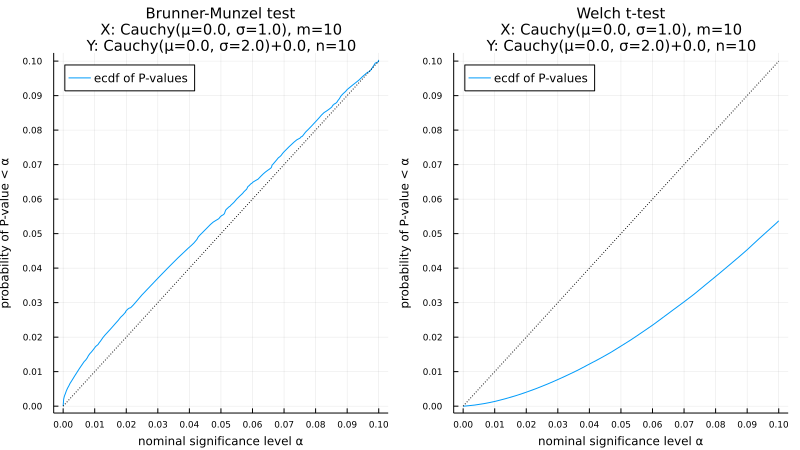

In [30]:
plot_pvals(; distx = Cauchy(0, 1), disty = Cauchy(0, 2), m = 10, n = 10, Δμ = 0.0)

In [31]:
m, n = 10, 10
X = rand(Normal(0, 1), m)
Y = rand(Normal(0, 4), n)
@show brunner_munzel(X, Y).confint_location
@show confint_welch(X, Y);

(brunner_munzel(X, Y)).confint_location = [-4.4133596192811435, 5.447806175376636]
confint_welch(X, Y) = [-2.437292072542138, 5.036331007921503]


In [32]:
function plot_confints(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 100, kwargs...)
    BM = fill(zeros(2), 0)
    W = fill(zeros(2), 0)
    for _ in 1:L
        X = rand(distx, m)
        Y = rand(disty, n)
        push!(BM, brunner_munzel(X, Y).confint_location)
        push!(W, confint_welch(X, Y))
    end
    P = plot()
    for i in 1:L
        plot!(fill(i, 2), [first(BM[i]), last(BM[i])]; label="", c=1, lw=2)
        plot!(fill(i+0.3, 2), [first(W[i]), last(W[i])]; label="", c=2, lw=2)
    end
    title!("X: $(distname(distx)), m=$m,   Y: $(distname(disty)), n=$n")
    plot!(size=(1000, 250))
end

plot_confints (generic function with 1 method)

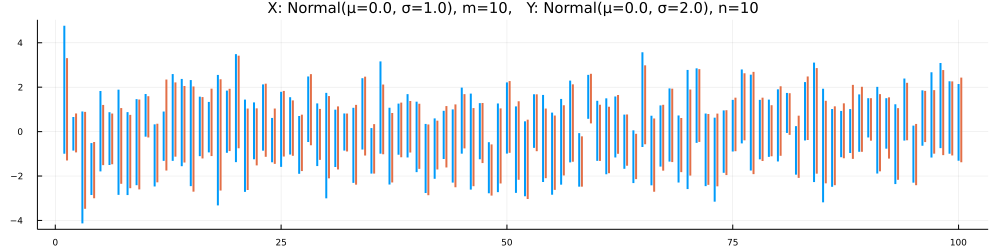

In [33]:
plot_confints(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

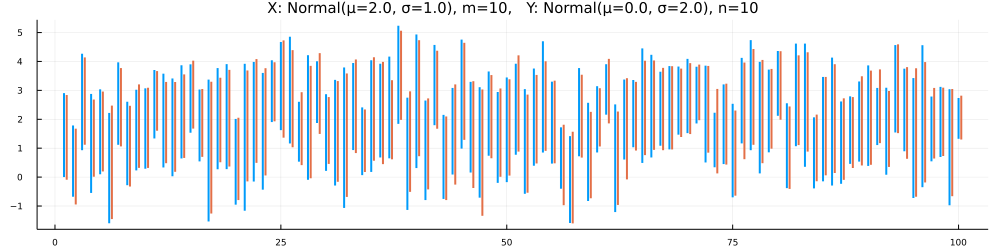

In [34]:
plot_confints(distx = Normal(2, 1), disty = Normal(0, 2), m = 10, n = 10)

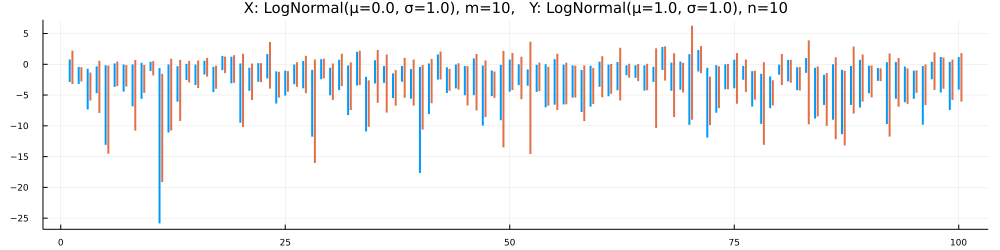

In [35]:
plot_confints(distx = LogNormal(0), disty = LogNormal(1), m = 10, n = 10)

In [36]:
function plot_limits(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 1000, kwargs...)
    
    @show distx, m
    @show disty, n

    BM = fill(zeros(2), 0)
    W = fill(zeros(2), 0)
    for _ in 1:L
        X = rand(distx, m)
        Y = rand(disty, n)
        push!(BM, brunner_munzel(X, Y).confint_location)
        push!(W, confint_welch(X, Y))
    end

    lower = [(first(BM[i]), first(W[i])) for i in 1:L]
    upper = [(last(BM[i]), last(W[i])) for i in 1:L]

    P1 = scatter(lower; label="", msc=:auto, ms=2, ma=0.5)
    plot!(identity; label="")
    plot!(xguide="Brunner-Munzel", yguide="Welch")
    title!("lower")

    P2 = scatter(upper; label="", msc=:auto, ms=2, ma=0.5)
    plot!(identity; label="")
    plot!(xguide="Brunner-Munzel", yguide="Welch")
    title!("upper")

    plot(P1, P2; size=(640, 320))
end

plot_limits (generic function with 1 method)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (Normal{Float64}(μ=0.0, σ=2.0), 10)


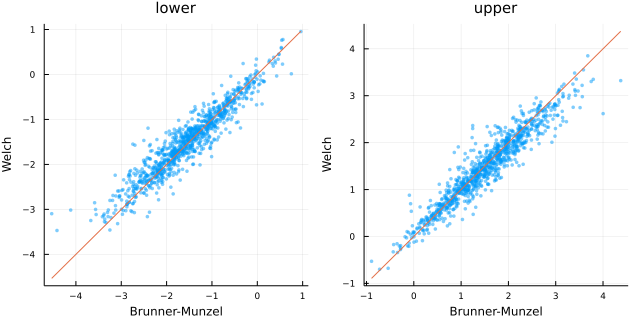

In [37]:
plot_limits(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

(distx, m) = (Normal{Float64}(μ=2.0, σ=1.0), 10)
(disty, n) = (Normal{Float64}(μ=0.0, σ=2.0), 10)


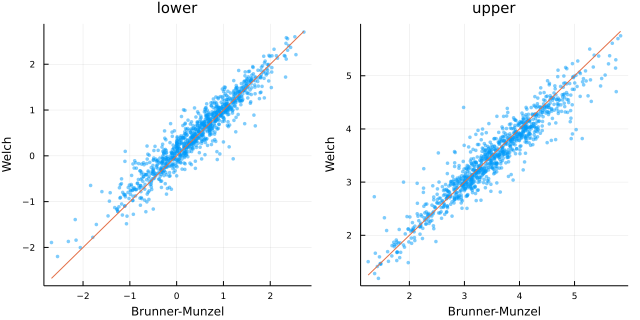

In [38]:
plot_limits(distx = Normal(2, 1), disty = Normal(0, 2), m = 10, n = 10)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 10)


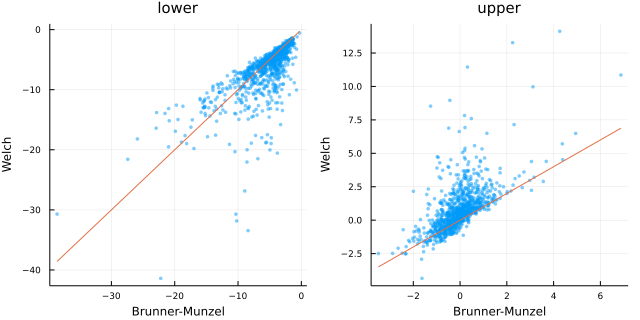

In [39]:
plot_limits(distx = LogNormal(), disty = LogNormal(1), m = 10, n = 10)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 40)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 40)


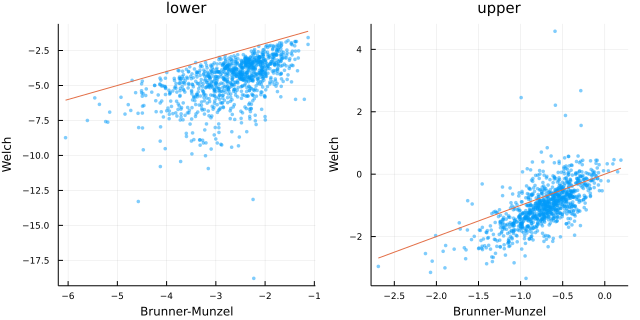

In [40]:
plot_limits(distx = LogNormal(), disty = LogNormal(1), m = 40, n = 40)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 160)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 160)


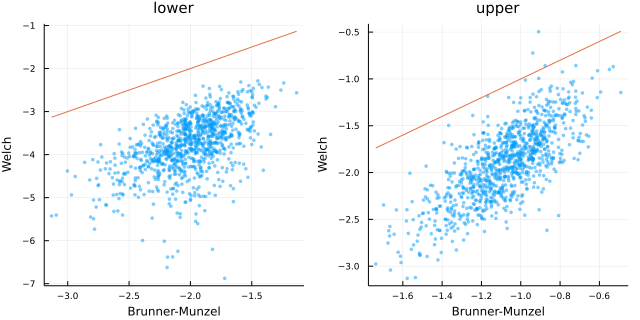

In [41]:
plot_limits(distx = LogNormal(), disty = LogNormal(1), m = 160, n = 160)